In [1]:
import os
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import torch
from torch import nn
from torch import utils
from torch.utils.data import DataLoader, Dataset
from torch import optim

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms

print(torchvision.__version__)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

0.12.0+cpu


In [2]:
class ShortTextDataset(Dataset):
    def __init__(self, data_folder: str, mapping_path: str, img_width: int, img_height: int):
        self.data_folder = data_folder
        self.width = img_width
        self.height = img_height
        self.mapping = pd.read_csv(mapping_path, index_col=0)
        self.files_list = [item for item in os.listdir(data_folder)]
        
    def __getitem__(self, ind: int):
        img = Image.open(os.path.normpath(self.data_folder + f'/{self.mapping["path"][ind]}')).convert("RGB")
        
        return img.resize((self.width, self.height)), self.mapping['label'][ind]
    
    def __len__(self):
        return self.mapping.shape[0]

In [3]:
train_ds = ShortTextDataset('/kaggle/input/russiancapitalizedocr/train/', 
                            mapping_path='/kaggle/input/russiancapitalizedocr/mapping.csv', 
                            img_height=32,
                            img_width=256)

(<matplotlib.image.AxesImage at 0x7f496e194ad0>, 'АЛЕКСАНДРОВИЧ ')

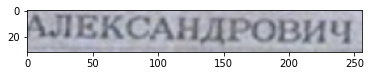

In [4]:
plt.imshow(train_ds[0][0]), train_ds[0][1]

In [13]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input_batch):
        recurrent, _ = self.rnn(input_batch)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, img_batch):
        # conv features
        conv = self.cnn(img_batch)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output

In [ ]:
class alignCollate(object):

    def __init__(self, imgH=32, imgW=100, keep_ratio=False, min_ratio=1):
        self.imgH = imgH
        self.imgW = imgW
        self.keep_ratio = keep_ratio
        self.min_ratio = min_ratio

    def __call__(self, batch):
        images, labels = zip(*batch)

        imgH = self.imgH
        imgW = self.imgW
        if self.keep_ratio:
            ratios = []
            for image in images:
                w, h = image.size
                ratios.append(w / float(h))
            ratios.sort()
            max_ratio = ratios[-1]
            imgW = int(np.floor(max_ratio * imgH))
            imgW = max(imgH * self.min_ratio, imgW)  # assure imgH >= imgW

        transform = resizeNormalize((imgW, imgH))
        images = [transform(image) for image in images]
        images = torch.cat([t.unsqueeze(0) for t in images], 0)

        return images, labels

In [7]:
def get_model(train_ds, img_width, img_height):
    
    
    ## 
    model = CRNN(img_channel=3, img_width=img_width, img_height=img_height, num_class=len(alphabet))
    
    return model

In [9]:
def train(model, train_loader, optimizer, loss_func, epoch_num, scheduler):
    loss_history = list()
    
    plt.figure(figsize=(20, 12))
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    
    plt.title('Classifier loss')
    
    model.train()
    
    model.to(device)
    onvert_image = transforms.ToTensor()
    
    for epoch_step in range(epoch_num):
        model.train()
        
        ctc_loss = torch.zeros(1)
        
        for step, (imgs, targets) in enumerate(train_loader, 1): 
            
            ############################################## FROM HERE !!!
            cpu_images, cpu_texts = imgs, targets
            
            
            t, l = converter.encode(cpu_texts)
            
            
            images = list()
            targets = list()
            target_lengths = list()
            
            for img, target in zip(imgs, targets):
                images = convert_image(img).to(device)
                targets = target.to(device)
                target_lengths = torch.LongTensor(len(target))
            
            logits = model(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)
            
            input_lengths = torch.LongTensor([logits.size(0)] * images.size(0))
            target_lengths = torch.flatten(target_lengths)
            
            loss = loss_func(log_probs, targets, input_lengths, target_lengths)
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            ctc_loss += loss.item()
                
        if scheduler:
            scheduler.step()
        
        loss_history.append(ctc_loss / len(train_loader))
        
        print(f'Loss: {loss_history[-1]}')
    
    plt.plot(list(range(1, epoch_num + 1)), loss_history)
    
    return classifier_loss_history, regression_loss_history

In [ ]:
class strLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

In [10]:
model = get_model(train_ds, img_width=256, img_height=32)

train_loader = DataLoader(train_ds, batch_size=32, num_workers=2, shuffle=True, 
                          collate_fn=collate_fn=alignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio=opt.keep_ratio))



alphabet = 'АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ- '


nclass = len(alphabet) + 1
nc = 1
image_height = None

converter = strLabelConverter(alphabet)
criterion = CTCLoss()


crnn = CRNN(image_height, nc, nclass, opt.nh)


loss = torch.nn.CTCLoss()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=8)

torch.cuda.empty_cache()

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


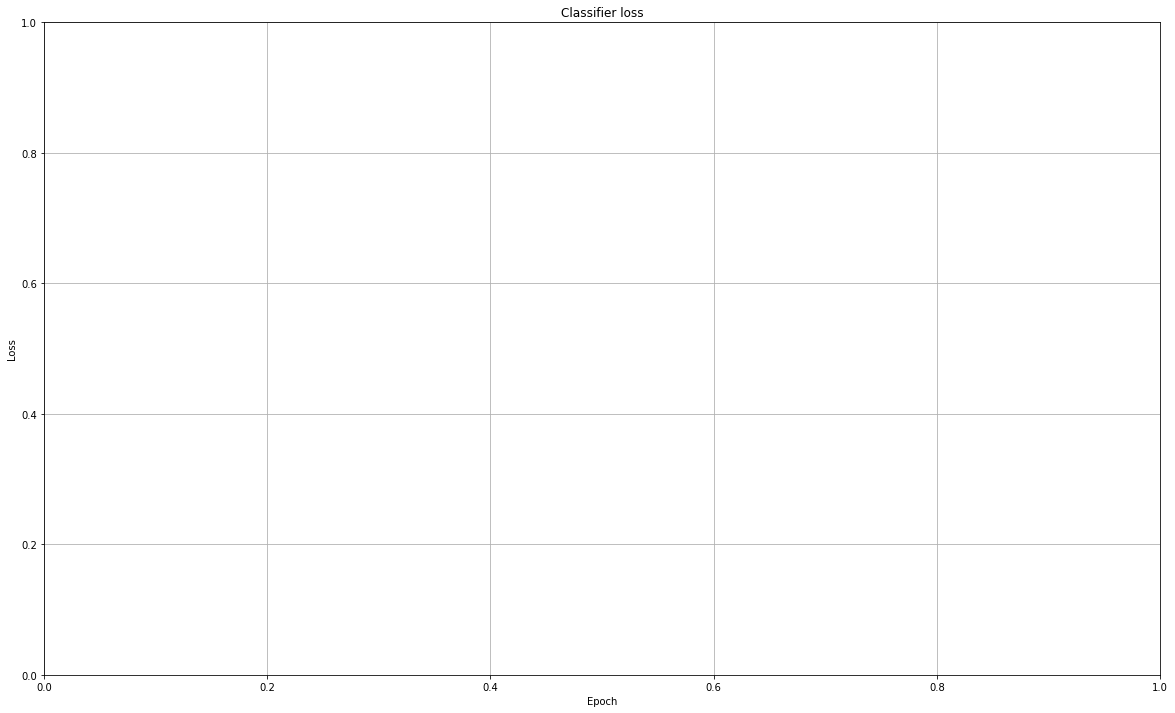

In [11]:
%%time
res = train(model, train_loader, optimizer, loss, 15, scheduler)

In [ ]:
def show_model_prediction(model, dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, num_workers=4, shuffle=True, collate_fn=collate_fn)
    
    img_count = len(dataset)
    
    fig, axes = plt.subplots(img_count, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(24, img_count * 20))
    
    model.eval()
    
    img_convert = transforms.ToTensor()
    
    plt_ind = 0
    
    for img_batch, target_batch in data_loader:        
        prep_img_batch = list((img_convert(img).to(device) for img in img_batch))        
        
        outputs = model(prep_img_batch)

        
        ##########################
        for temp_image, mod_answer in zip(img_batch, outputs):

            kept_ind = torchvision.ops.nms(mod_answer['boxes'], mod_answer['scores'], 0.8)
        
            mod_answer = mod_answer[list(np.array(kept_ind.cpu()))]

            temp_image = np.array(temp_image)
            # Convert RGB to BGR 
            temp_image = temp_image[:, :, ::-1].copy() 

            for box_ind, (box, label) in enumerate(zip(mod_answer['boxes'], mod_answer['labels']), 1):
                # unpack the bounding box
                x0 = int(box[0])
                y0 = int(box[1])
                x1 = int(box[2])
                y1 = int(box[3])
                

                cv2.rectangle(temp_image, (x0, y0), (x1, y1), (0, 0, 255), 1)
                cv2.putText(temp_image, str(box_ind), ((x0 + x1) // 2, (y0 + y1) // 2), 
                            cv2.FONT_HERSHEY_COMPLEX, 0.3, (0, 255, 0))

                axes[plt_ind, 1].text(0, 1 - box_ind / len(mod_answer['boxes']), 
                                      f'{box_ind} -> {dataset.labels_list[label]}', fontsize=15, transform=axes[plt_ind, 1].transAxes)


            img_obj = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)

            img_width, img_height, _ = img_obj.shape

            cv2.resize(img_obj, (int(3 * img_width), int(3 * img_height)))

            axes[plt_ind, 0].imshow(img_obj)
            axes[plt_ind, 1].axis('off')
            plt_ind += 1
        
    plt.show()

In [ ]:
%%time
show_model_prediction(model.to(device), test_ds)